In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, BatchNormalization
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, Flatten, Activation

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess 

from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model 

import os 
import matplotlib.pyplot as plt 

2023-06-09 17:50:37.675359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 17:50:37.829144: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-09 17:50:38.643079: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:/home/fashr003/anaconda3/lib/:/home/fashr00

In [ ]:
## CREATE Train, Val and Test DATASETS

IMAGE_SIZE = (224, 340)
CROP_SIZE = (224, 224)
BATCH_SIZE = 128

def dataset(ds_path, image_size=IMAGE_SIZE, crop_size=CROP_SIZE, batch_size=BATCH_SIZE, 
            train_split=0.7, val_split=0.1, test_split=0.2):
    # Create the image dataset
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=True, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    # Calculate the number of samples for each split
    num_samples = len(ds)
    num_train_samples = int(num_samples * train_split)
    num_val_samples = int(num_samples * val_split)
    num_test_samples = num_samples - num_train_samples - num_val_samples
    
    # Split the dataset
    ds_train = ds.take(num_train_samples)
    ds_val = ds.skip(num_train_samples).take(num_val_samples)
    ds_test = ds.skip(num_train_samples + num_val_samples).take(num_test_samples)

    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)

    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels

    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)

    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=True)
        return cropped_images, labels

    ds_train = ds_train.map(augment, tf.data.experimental.AUTOTUNE)
    ds_train = ds_train.map(crop, tf.data.experimental.AUTOTUNE)
    ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

    ds_val = ds_val.map(crop, tf.data.experimental.AUTOTUNE)
    ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

    ds_test = ds_test.map(crop, tf.data.experimental.AUTOTUNE)
    ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

    return ds_train, ds_val, ds_test 



In [ ]:
def plot_train_history(train_history, train_history2=None, title=""):
    if train_history2 is not None:
        acc = train_history.history['accuracy'] + train_history2.history['accuracy']
        val_acc = train_history.history['val_accuracy'] + train_history2.history['val_accuracy']
        loss = train_history.history['loss'] + train_history2.history['loss']
        val_loss = train_history.history['val_loss'] + train_history2.history['val_loss']
        init_epochs = len(train_history.history['accuracy'])
    else:
        acc = train_history.history['accuracy']
        val_acc = train_history.history['val_accuracy']
        loss = train_history.history['loss']
        val_loss = train_history.history['val_loss'] 

    fig = plt.figure(figsize=(16, 4))
    fig.patch.set_alpha(0.5)

    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    if train_history2 is not None:
        plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
    plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
            loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(title)

    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    if train_history2 is not None:
        plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
    plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
            loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.xlabel('Epochs')
    plt.title(title) 
    plt.show()

In [ ]:
def eval_model(model, test_loader, title):
    import numpy as np
    from sklearn.metrics import accuracy_score, classification_report

    y_true, y_pred = [], []
    for images, labels in test_loader:
        preds = model.predict(images)
        y_true.append(labels.numpy())
        y_pred.append(preds)

    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    y_probas = y_pred
    y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
    print('Accuracy: ', accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))

    from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
    from scikitplot.metrics import plot_confusion_matrix, plot_roc
    plot_confusion_matrix(y_true, y_pred, title=title)
    plot_confusion_matrix(y_true, y_pred, normalize=True, title=title) 
    plot_roc(y_true, y_probas, title=title) 

In [ ]:
def naive_inception_module(layer_in, f1, f2, f3):
        # 1x1 conv
        conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
        # 3x3 conv
        conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
        # 5x5 conv
        conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
        # 3x3 max pooling
        pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
        # concatenate filters, assumes filters/channels last
        layer_out = Concatenate()([conv1, conv3, conv5, pool])
        return layer_out

In [ ]:

base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))
# Print the layers and their names
print("ResNet50 Layers:")
for i, layer in enumerate(base_model.layers):
    print(f"Layer {i}: {layer.name}")

2023-06-09 17:50:50.378033: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-06-09 17:50:50.378086: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ubuntu
2023-06-09 17:50:50.378095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ubuntu
2023-06-09 17:50:50.378236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.105.1
2023-06-09 17:50:50.378266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.86.1
2023-06-09 17:50:50.378272: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.86.1 does not match DSO version 515.105.1 -- cannot find working devices in this configuration
2023-06-09 17:50:50.

ResNet50 Layers:
Layer 0: input_1
Layer 1: conv1_pad
Layer 2: conv1_conv
Layer 3: conv1_bn
Layer 4: conv1_relu
Layer 5: pool1_pad
Layer 6: pool1_pool
Layer 7: conv2_block1_1_conv
Layer 8: conv2_block1_1_bn
Layer 9: conv2_block1_1_relu
Layer 10: conv2_block1_2_conv
Layer 11: conv2_block1_2_bn
Layer 12: conv2_block1_2_relu
Layer 13: conv2_block1_0_conv
Layer 14: conv2_block1_3_conv
Layer 15: conv2_block1_0_bn
Layer 16: conv2_block1_3_bn
Layer 17: conv2_block1_add
Layer 18: conv2_block1_out
Layer 19: conv2_block2_1_conv
Layer 20: conv2_block2_1_bn
Layer 21: conv2_block2_1_relu
Layer 22: conv2_block2_2_conv
Layer 23: conv2_block2_2_bn
Layer 24: conv2_block2_2_relu
Layer 25: conv2_block2_3_conv
Layer 26: conv2_block2_3_bn
Layer 27: conv2_block2_add
Layer 28: conv2_block2_out
Layer 29: conv2_block3_1_conv
Layer 30: conv2_block3_1_bn
Layer 31: conv2_block3_1_relu
Layer 32: conv2_block3_2_conv
Layer 33: conv2_block3_2_bn
Layer 34: conv2_block3_2_relu
Layer 35: conv2_block3_3_conv
Layer 36: con

In [ ]:
def resnetinnet_builder(finetune=False, model=None, trainable_blocks=None, print_trainable=False):
    
    base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))
    shallow_resnet = tf.keras.Model(inputs    = base_model.input, 
                                      outputs   = base_model.get_layer('conv3_block4_out').output, 
                                      name      = 'resnet50_shallow')
    if finetune==False:
        shallow_resnet.trainable = False  
        
        p1_layer = tf.keras.layers.Lambda(resnet50_preprocess, name='resnet50_Preprocess')
        image_input = tf.keras.Input((224, 224, 3), name='Image_Input')
        p1_tensor = p1_layer(image_input)
        
        out = shallow_resnet(p1_tensor)
        shallow_resnet = tf.keras.Model(inputs=image_input, outputs=out)
        out = naive_inception_module(shallow_resnet.output, 64, 128, 32)
        bn1 = tf.keras.layers.BatchNormalization(name='BN')(out)
        f = tf.keras.layers.Flatten()(bn1)
        dropout = tf.keras.layers.Dropout(0.4, name='Dropout')(f)
        desne = tf.keras.layers.Dense(2, activation='softmax', name='Predictions')(dropout)

        model = tf.keras.Model(inputs=shallow_resnet.input, outputs=desne)
        
    else:
        #trainable_blocks = ["conv1", "conv2", "conv3"] 
        model.get_layer('resnet50_shallow').trainable = False
        for layer in model.get_layer('resnet50_shallow').layers:
            for block_name in trainable_blocks:
                if layer.name.startswith(block_name):
                    layer.trainable = True 
            if print_trainable:
                print(layer.name, layer.trainable) 

    return model


In [ ]:
def lr_schedule(epoch, lr_warmup_epochs = 25, lr_min = 1e-5, lr_max = 5e-5,  lr_exp_decay = 0.8):
    lr_start = lr_min 
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr 

In [ ]:
def model_dataset_epoch(model, train_set, val_set, test_set, epoch, folder_path, strategy="train", plot_title=""):
    # Define optimizer, Compile model, Define callbacks, Train the model
    if strategy=="train":
        opt = keras.optimizers.Adam(learning_rate=0.001) 
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) 
        callbacks = [
            ModelCheckpoint(monitor='val_accuracy',filepath=folder_path+"model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True),
            tf.keras.callbacks.TensorBoard(log_dir=folder_path+'tb_logdir/')
        ] 
        init_epochs = epoch
        train_history = model.fit(train_set, epochs=init_epochs, validation_data=val_set, verbose=1, callbacks=callbacks) 
        plot_train_history(train_history, title=plot_title)  

        # Load best saved model
        files = os.listdir(folder_path) 
        files.sort(key=lambda x: os.path.getmtime(os.path.join(folder_path, x)))
        last_file = files[-1]
        model_path = folder_path+last_file  
        print('Best model path: ', model_path)
        best_model = load_model(model_path)

        # Evaluate the best model 
        best_model.evaluate(test_set)   
        eval_model(best_model, test_set, title=plot_title)  
    
    elif strategy=="finetune":
        model.compile('adam', 'categorical_crossentropy', metrics=['accuracy']) 

        cbs = [
            keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True),
            ModelCheckpoint(monitor='val_accuracy',filepath=folder_path+"model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True),
            tf.keras.callbacks.TensorBoard(log_dir=folder_path+'tb_logdir/')
        ] 

        train_history = model.fit(train_set, epochs=epoch+epoch, 
                                    validation_data=val_set,
                                    initial_epoch=epoch,
                                    callbacks=cbs,
                                    verbose=1)
        
        # Load best saved model
        files = os.listdir(folder_path) 
        files.sort(key=lambda x: os.path.getmtime(os.path.join(folder_path, x)))
        last_file = files[-1]
        model_path = folder_path+last_file  
        print('Best model path: ', model_path)
        best_model = load_model(model_path)

        # Evaluate the best model 
        best_model.evaluate(test_set)   
        eval_model(best_model, test_set, title=plot_title) 
        
    
    return train_history, model  

### **400X** 

Found 1820 files belonging to 2 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50_Preprocess (Lambda)   (None, 224, 224, 3)  0           ['Image_Input[0][0]']            
                                                                                                  
 resnet50_shallow (Functional)  (None, 28, 28, 5

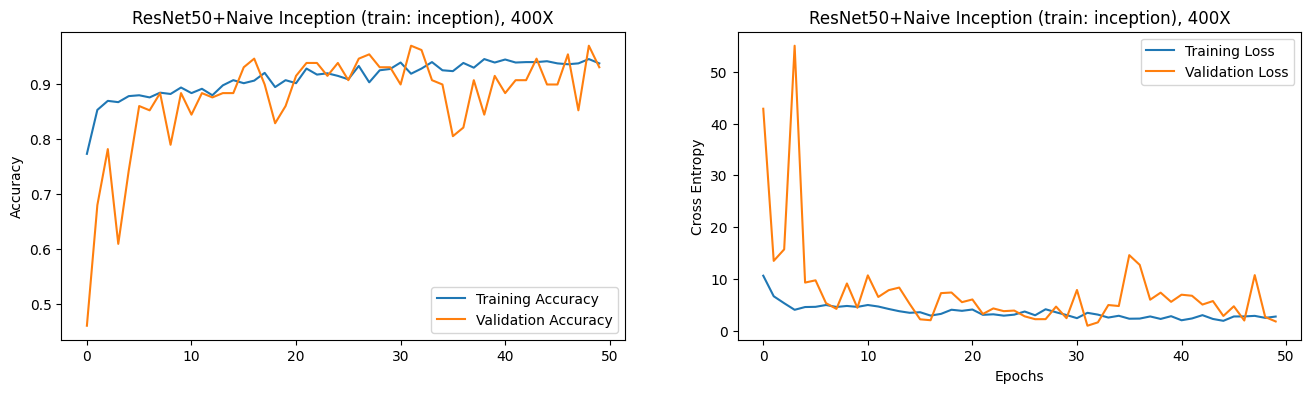

Best model path:  ResNet50_Incept_v01/400X/model-weights.32-0.968750.hdf5
1/1 [==============================] - 1s 639ms/step
Accuracy:  0.941747572815534
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       135
           1       0.92      1.00      0.96       277

    accuracy                           0.94       412
   macro avg       0.96      0.91      0.93       412
weighted avg       0.95      0.94      0.94       412

Found 1820 files belonging to 2 classes.
input_2 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_r

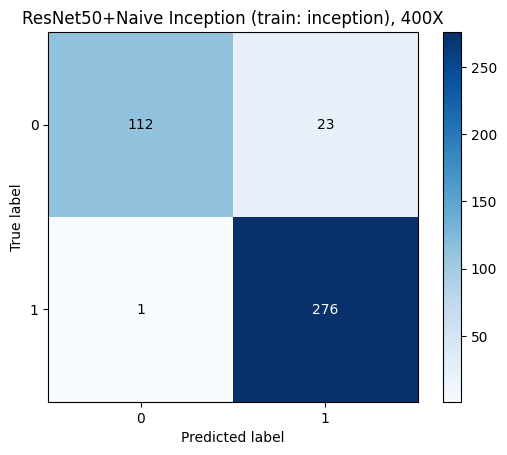

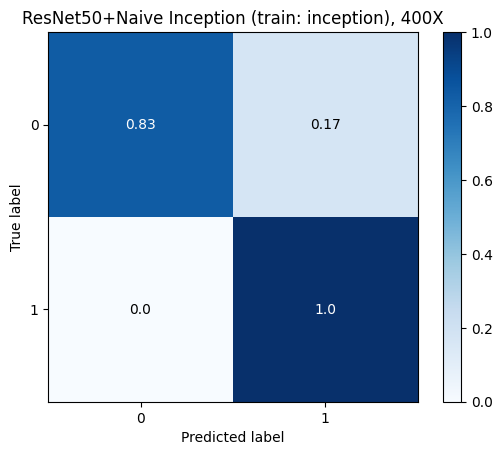

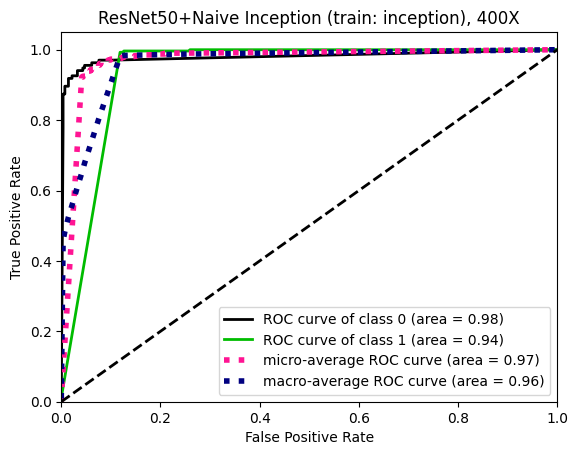

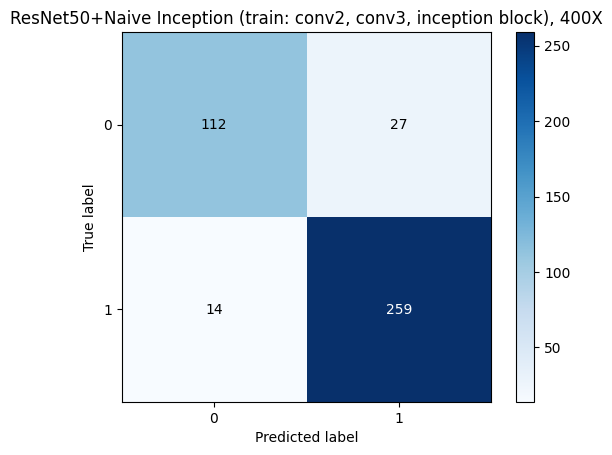

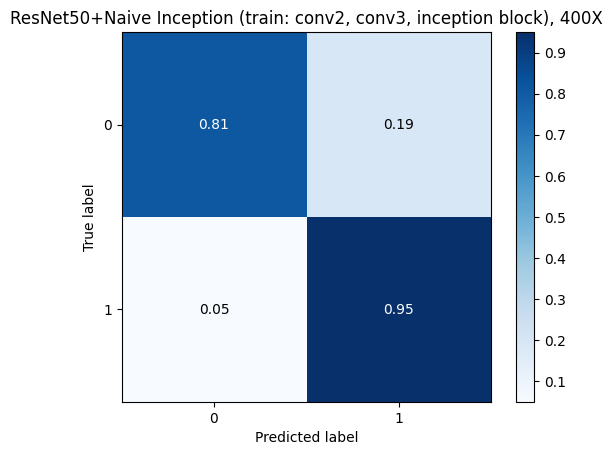

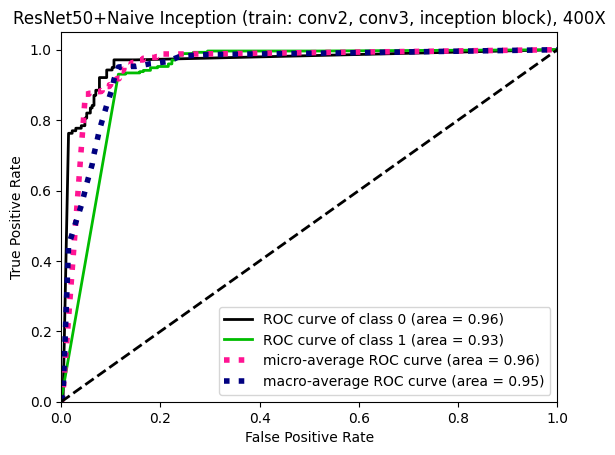

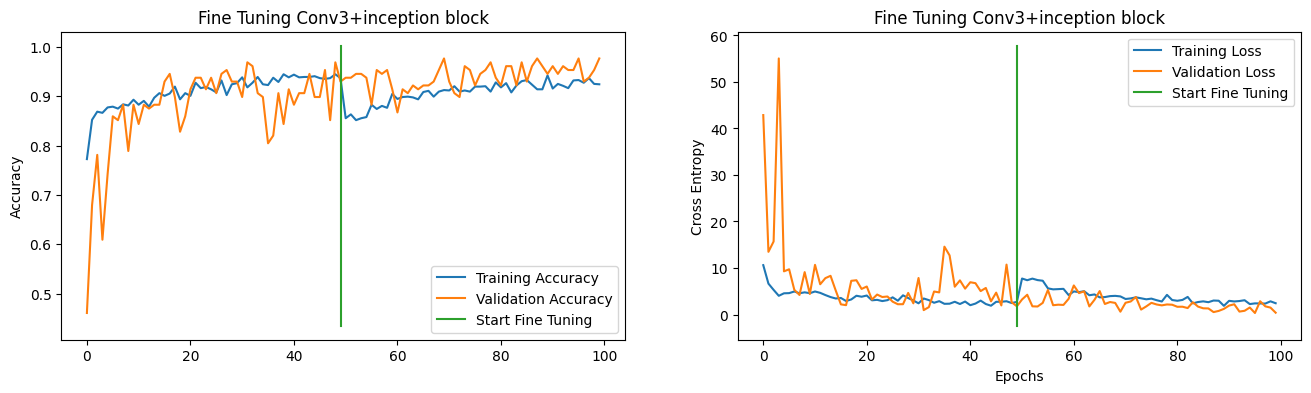

input_2 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv True
conv2_block1_1_bn True
conv2_block1_1_relu True
conv2_block1_2_conv True
conv2_block1_2_bn True
conv2_block1_2_relu True
conv2_block1_0_conv True
conv2_block1_3_conv True
conv2_block1_0_bn True
conv2_block1_3_bn True
conv2_block1_add True
conv2_block1_out True
conv2_block2_1_conv True
conv2_block2_1_bn True
conv2_block2_1_relu True
conv2_block2_2_conv True
conv2_block2_2_bn True
conv2_block2_2_relu True
conv2_block2_3_conv True
conv2_block2_3_bn True
conv2_block2_add True
conv2_block2_out True
conv2_block3_1_conv True
conv2_block3_1_bn True
conv2_block3_1_relu True
conv2_block3_2_conv True
conv2_block3_2_bn True
conv2_block3_2_relu True
conv2_block3_3_conv True
conv2_block3_3_bn True
conv2_block3_add True
conv2_block3_out True
conv3_block1_1_conv True
conv3_block1_1_bn True
conv3_block1_1_relu True
conv3_block1_2_conv True
conv3_block1_2_bn True
conv3

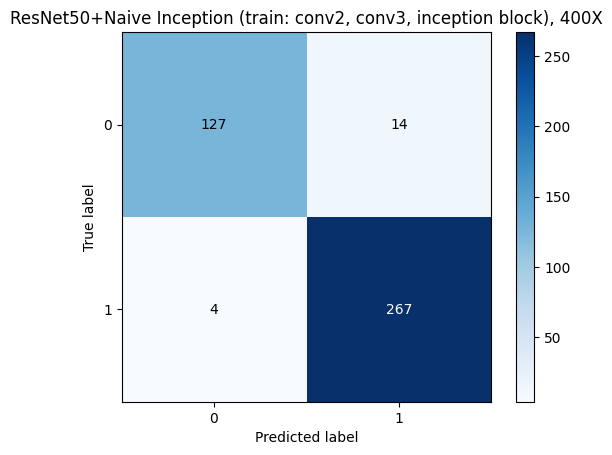

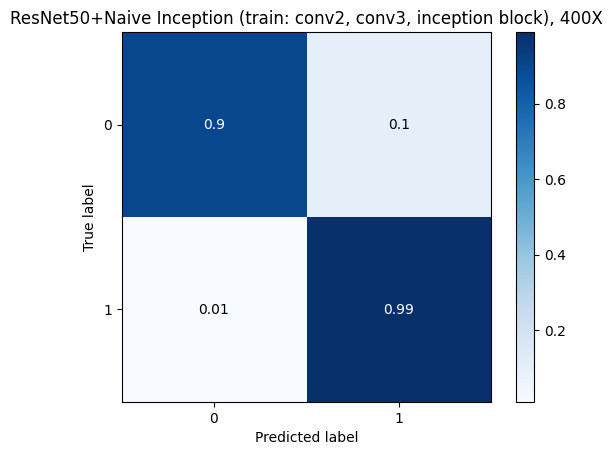

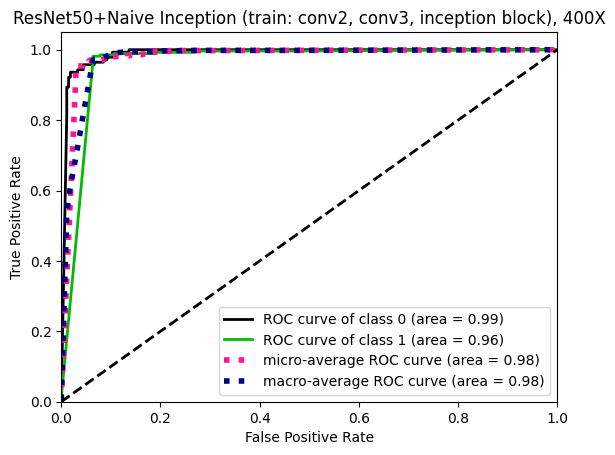

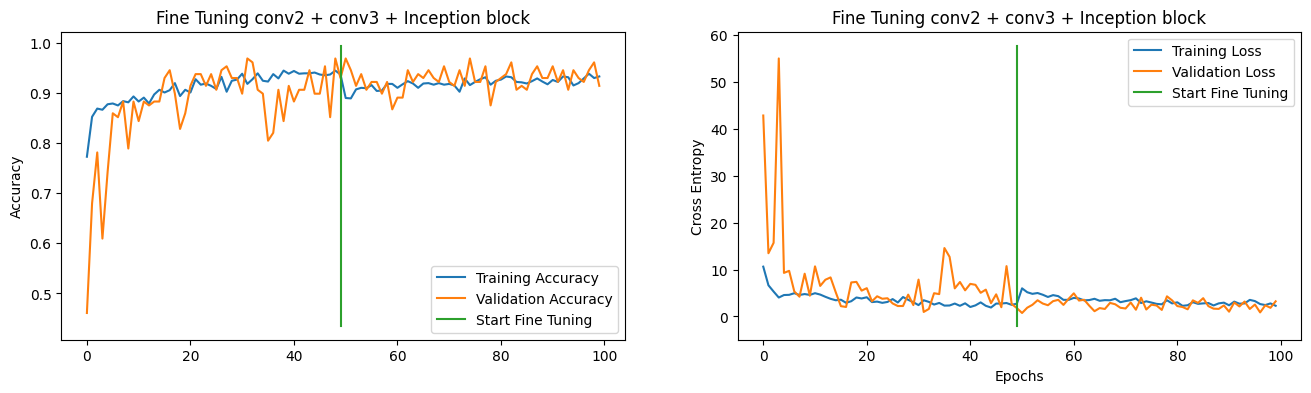

input_2 False
conv1_pad True
conv1_conv True
conv1_bn True
conv1_relu True
pool1_pad False
pool1_pool False
conv2_block1_1_conv True
conv2_block1_1_bn True
conv2_block1_1_relu True
conv2_block1_2_conv True
conv2_block1_2_bn True
conv2_block1_2_relu True
conv2_block1_0_conv True
conv2_block1_3_conv True
conv2_block1_0_bn True
conv2_block1_3_bn True
conv2_block1_add True
conv2_block1_out True
conv2_block2_1_conv True
conv2_block2_1_bn True
conv2_block2_1_relu True
conv2_block2_2_conv True
conv2_block2_2_bn True
conv2_block2_2_relu True
conv2_block2_3_conv True
conv2_block2_3_bn True
conv2_block2_add True
conv2_block2_out True
conv2_block3_1_conv True
conv2_block3_1_bn True
conv2_block3_1_relu True
conv2_block3_2_conv True
conv2_block3_2_bn True
conv2_block3_2_relu True
conv2_block3_3_conv True
conv2_block3_3_bn True
conv2_block3_add True
conv2_block3_out True
conv3_block1_1_conv True
conv3_block1_1_bn True
conv3_block1_1_relu True
conv3_block1_2_conv True
conv3_block1_2_bn True
conv3_blo

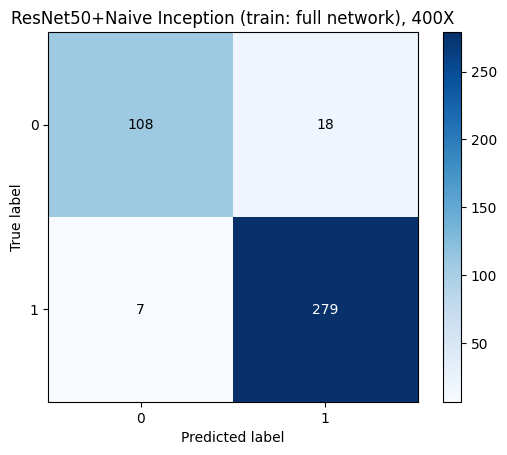

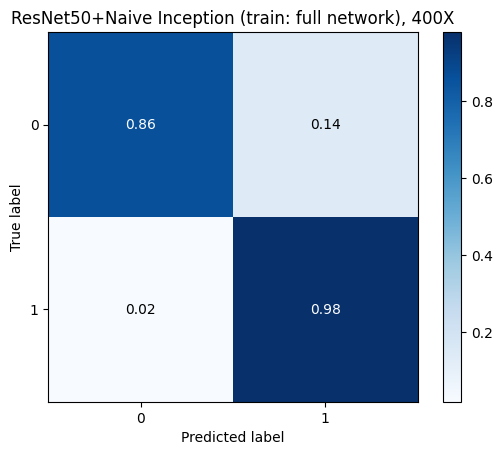

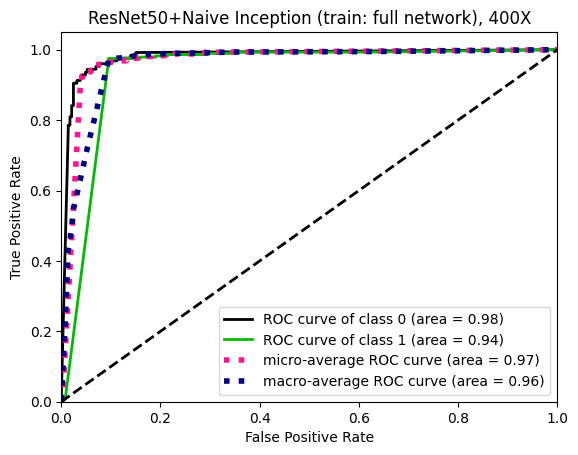

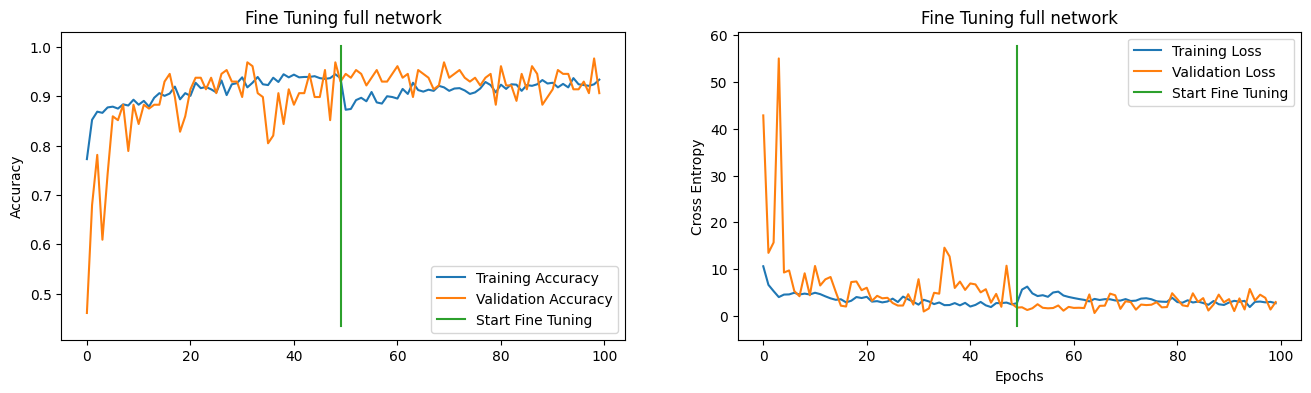

In [ ]:
# Create dataset train, val, test 
train_400x, val_400x, test_400x = dataset('400/') 
iters = 50

folder_proposed_1_400x = "ResNet50_Incept_v01/400X/"
model = resnetinnet_builder() 
model.summary() 
history_400x, model_400x = model_dataset_epoch(model, train_400x, val_400x, test_400x, epoch=iters, folder_path=folder_proposed_1_400x,
                    strategy="train", plot_title="ResNet50+Naive Inception (train: inception), 400X") 


# Create new train set for finetuning 
train_400x_n, _ , _ = dataset('400/') 
# Fine tuning of Conv3 + Inception block
folder_proposed_1_400x = "ResNet50_Incept_v02/400X/"
model = resnetinnet_builder(finetune=True, model=model_400x, trainable_blocks=['conv3'], print_trainable=True) 
model.summary() 
history_400x_v1, model_400x_v1 = model_dataset_epoch(model, train_400x_n, val_400x, test_400x, epoch=iters, folder_path=folder_proposed_1_400x,
                    strategy="finetune", plot_title="ResNet50+Naive Inception (train: conv3, inception block), 400X") 
plot_train_history(history_400x, history_400x_v1, title="Fine Tuning Conv3+inception block")  


# Fine tuning of conv2 + conv3 + Inception block
folder_proposed_2_400x = "ResNet50_Incept_v03/400X/"
model = resnetinnet_builder(finetune=True, model=model_400x, trainable_blocks=['conv2', 'conv3'], print_trainable=True) 
model.summary() 
history_400x_v2, model_400x_v2 = model_dataset_epoch(model, train_400x_n, val_400x, test_400x, epoch=iters, folder_path=folder_proposed_2_400x,
                    strategy="finetune", plot_title="ResNet50+Naive Inception (train: conv2, conv3, inception block), 400X") 
plot_train_history(history_400x, history_400x_v2, title="Fine Tuning conv2 + conv3 + Inception block")  


# Fine tuning of conv1 + conv2 + conv3 + Inception block
folder_proposed_3_400x = "ResNet50_Incept_v04/400X/"
model = resnetinnet_builder(finetune=True, model=model_400x, trainable_blocks=['conv1','conv2', 'conv3'], print_trainable=True) 
model.summary() 
history_400x_v3, model_400x_v3 = model_dataset_epoch(model, train_400x_n, val_400x, test_400x, epoch=iters, folder_path=folder_proposed_3_400x,
                    strategy="finetune", plot_title="ResNet50+Naive Inception (train: full network), 400X") 
plot_train_history(history_400x, history_400x_v3, title="Fine Tuning full network")  



### **40X**

Found 1995 files belonging to 2 classes.
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50_Preprocess (Lambda)   (None, 224, 224, 3)  0           ['Image_Input[0][0]']            
                                                                                                  
 resnet50_shallow (Functional)  (None, 28, 28, 512)  1460096     ['resnet50_Preprocess[0][0]']    
                                                                                                  
 conv2d_6 (Conv2D)              (None, 28, 28, 64) 

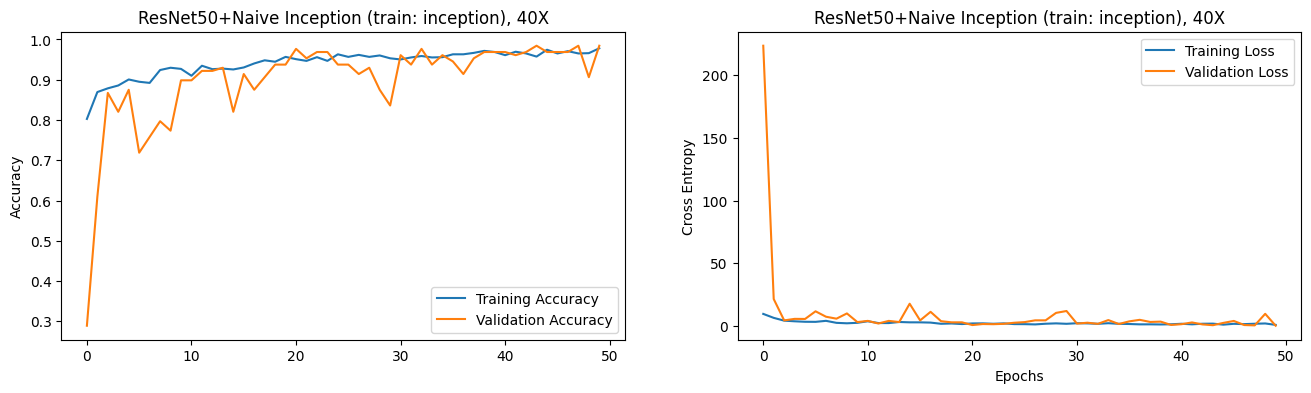

Best model path:  ResNet50_Incept_v01/40X/model-weights.44-0.984375.hdf5
3/3 [==============================] - 1s 129ms/step
Accuracy:  0.9782135076252724
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       136
           1       0.99      0.98      0.98       323

    accuracy                           0.98       459
   macro avg       0.97      0.98      0.97       459
weighted avg       0.98      0.98      0.98       459

input_7 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2

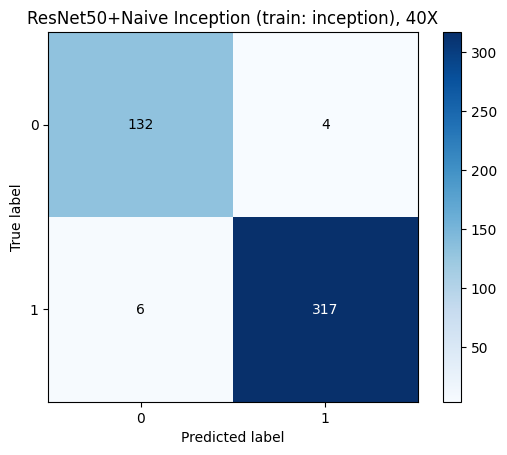

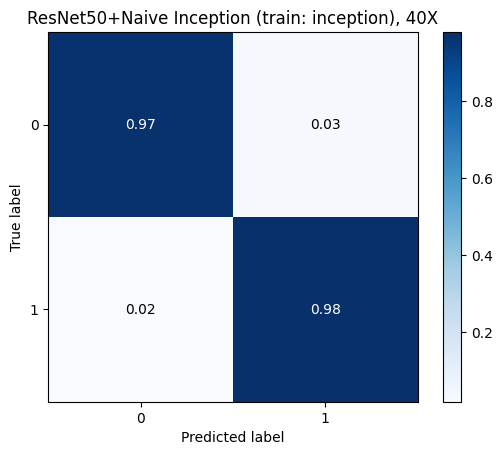

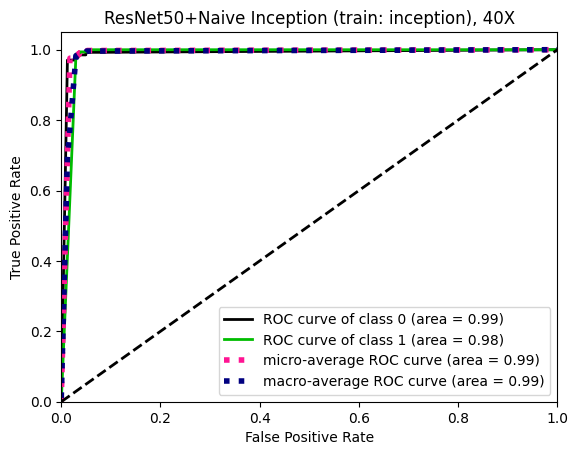

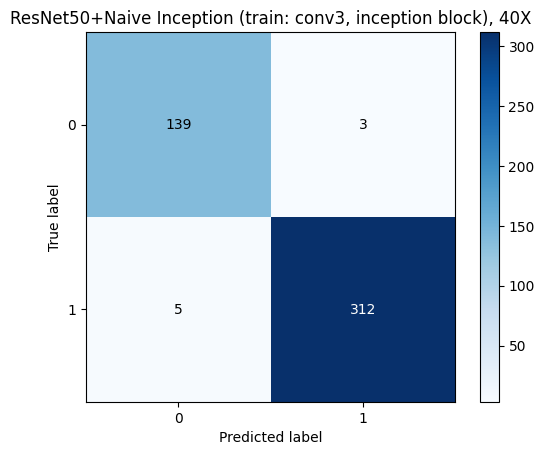

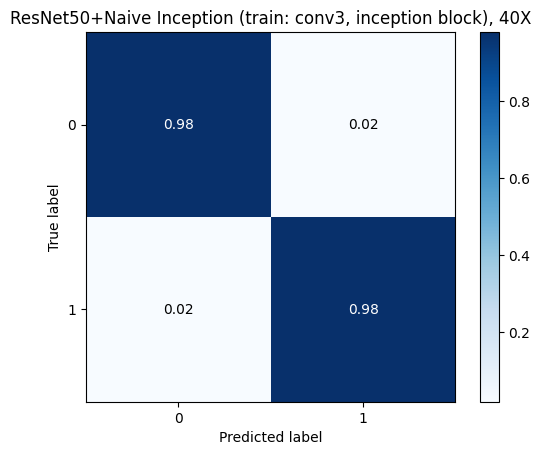

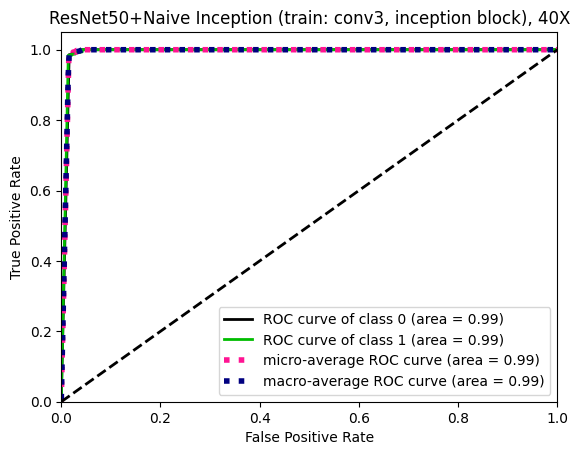

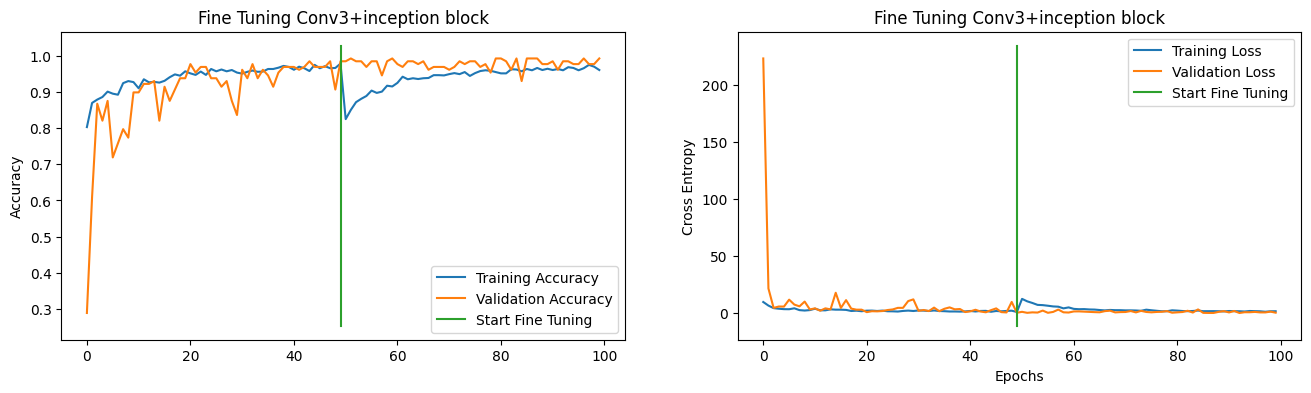

input_7 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv True
conv2_block1_1_bn True
conv2_block1_1_relu True
conv2_block1_2_conv True
conv2_block1_2_bn True
conv2_block1_2_relu True
conv2_block1_0_conv True
conv2_block1_3_conv True
conv2_block1_0_bn True
conv2_block1_3_bn True
conv2_block1_add True
conv2_block1_out True
conv2_block2_1_conv True
conv2_block2_1_bn True
conv2_block2_1_relu True
conv2_block2_2_conv True
conv2_block2_2_bn True
conv2_block2_2_relu True
conv2_block2_3_conv True
conv2_block2_3_bn True
conv2_block2_add True
conv2_block2_out True
conv2_block3_1_conv True
conv2_block3_1_bn True
conv2_block3_1_relu True
conv2_block3_2_conv True
conv2_block3_2_bn True
conv2_block3_2_relu True
conv2_block3_3_conv True
conv2_block3_3_bn True
conv2_block3_add True
conv2_block3_out True
conv3_block1_1_conv True
conv3_block1_1_bn True
conv3_block1_1_relu True
conv3_block1_2_conv True
conv3_block1_2_bn True
conv3

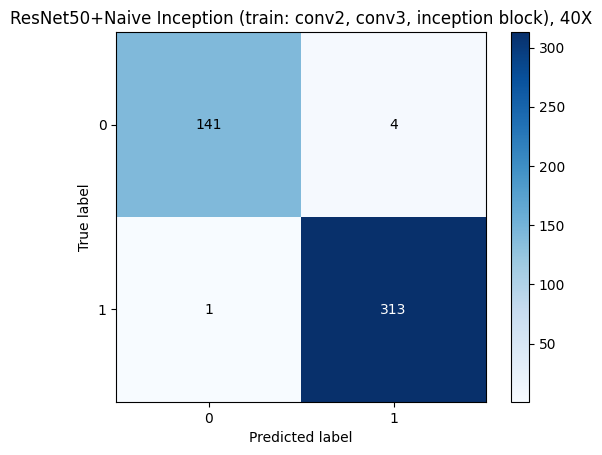

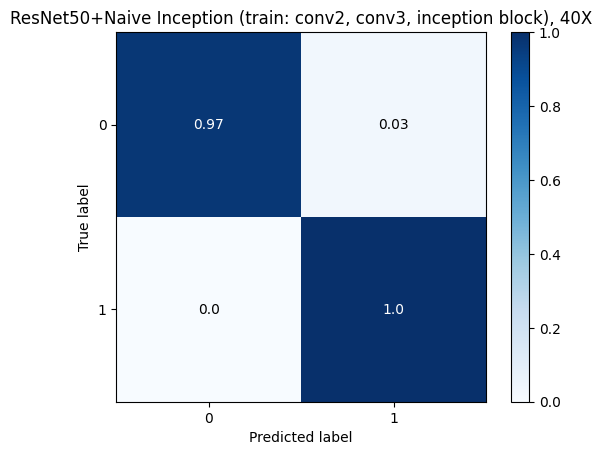

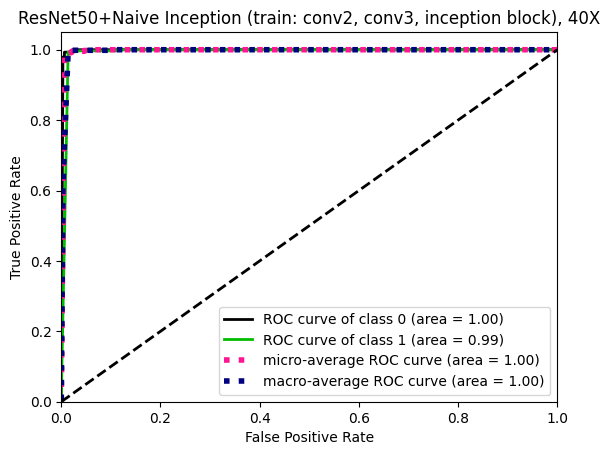

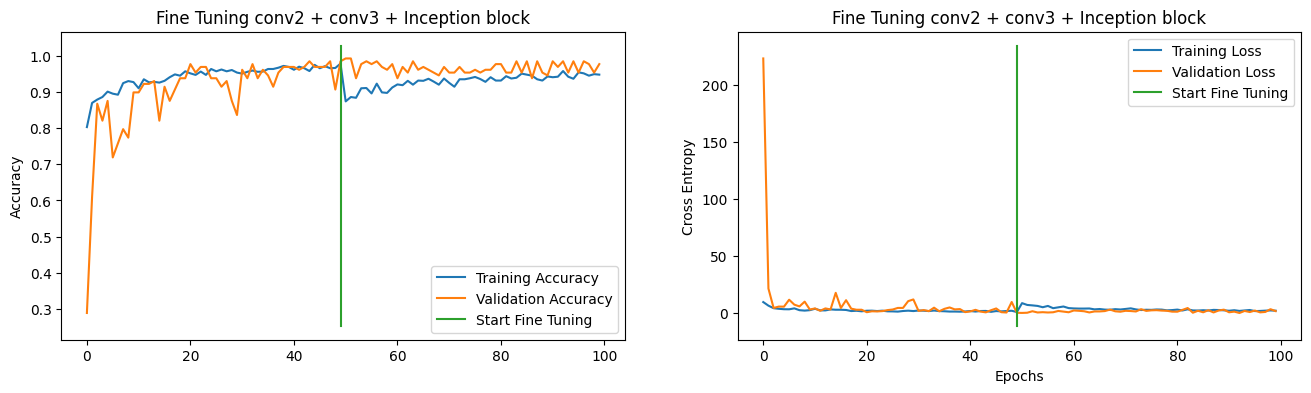

input_7 False
conv1_pad True
conv1_conv True
conv1_bn True
conv1_relu True
pool1_pad False
pool1_pool False
conv2_block1_1_conv True
conv2_block1_1_bn True
conv2_block1_1_relu True
conv2_block1_2_conv True
conv2_block1_2_bn True
conv2_block1_2_relu True
conv2_block1_0_conv True
conv2_block1_3_conv True
conv2_block1_0_bn True
conv2_block1_3_bn True
conv2_block1_add True
conv2_block1_out True
conv2_block2_1_conv True
conv2_block2_1_bn True
conv2_block2_1_relu True
conv2_block2_2_conv True
conv2_block2_2_bn True
conv2_block2_2_relu True
conv2_block2_3_conv True
conv2_block2_3_bn True
conv2_block2_add True
conv2_block2_out True
conv2_block3_1_conv True
conv2_block3_1_bn True
conv2_block3_1_relu True
conv2_block3_2_conv True
conv2_block3_2_bn True
conv2_block3_2_relu True
conv2_block3_3_conv True
conv2_block3_3_bn True
conv2_block3_add True
conv2_block3_out True
conv3_block1_1_conv True
conv3_block1_1_bn True
conv3_block1_1_relu True
conv3_block1_2_conv True
conv3_block1_2_bn True
conv3_blo

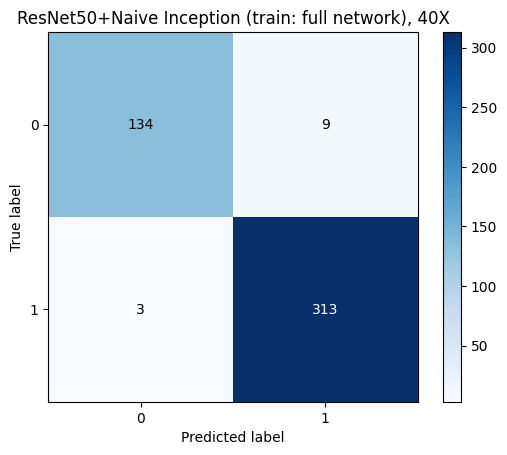

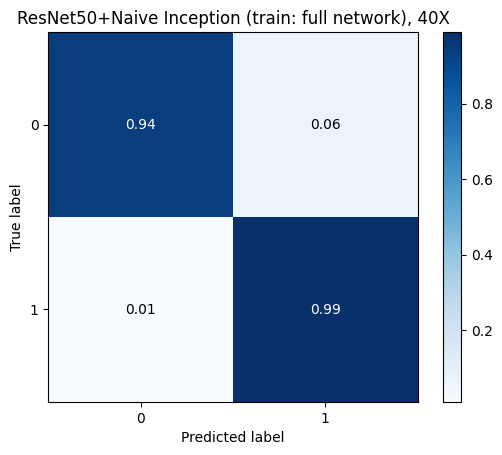

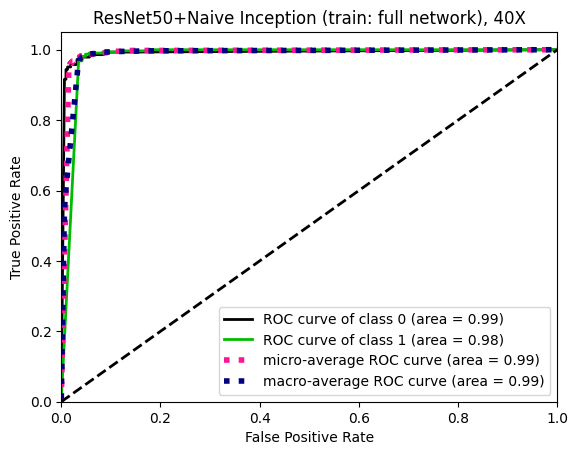

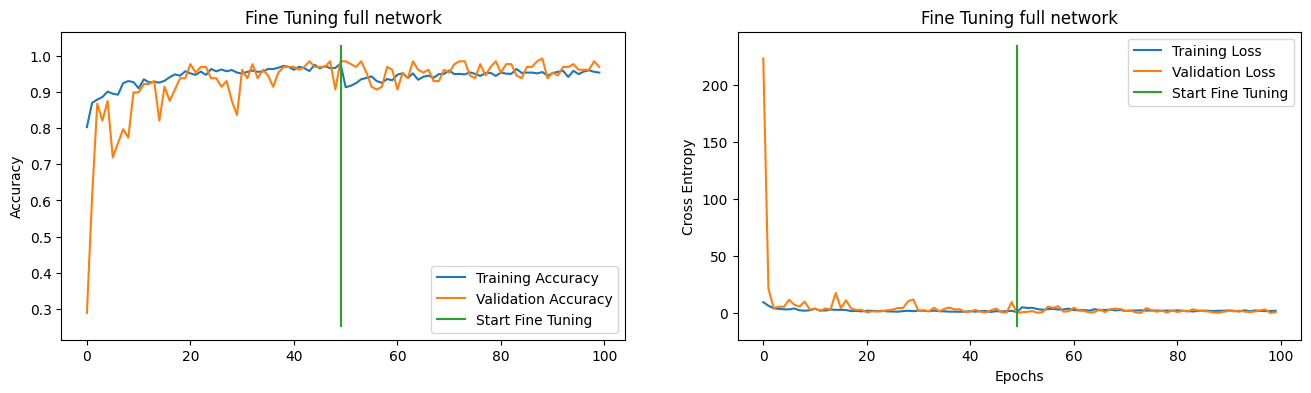

In [ ]:
# Create dataset train, val, test 
train_40x, val_40x, test_40x = dataset('40/') 
iters = 50

folder_proposed_1_40x = "ResNet50_Incept_v01/40X/"
model = resnetinnet_builder() 
model.summary() 
history_40x, model_40x = model_dataset_epoch(model, train_40x, val_40x, test_40x, epoch=iters, folder_path=folder_proposed_1_40x,
                    strategy="train", plot_title="ResNet50+Naive Inception (train: inception), 40X") 


# Fine tuning of Conv3 + Inception block
folder_proposed_1_40x = "ResNet50_Incept_v02/40X/"
model = resnetinnet_builder(finetune=True, model=model_40x, trainable_blocks=['conv3'], print_trainable=True) 
model.summary() 
history_40x_v1, model_40x_v1 = model_dataset_epoch(model, train_40x, val_40x, test_40x, epoch=iters, folder_path=folder_proposed_1_40x,
                    strategy="finetune", plot_title="ResNet50+Naive Inception (train: conv3, inception block), 40X") 
plot_train_history(history_40x, history_40x_v1, title="Fine Tuning Conv3+inception block")  


# Fine tuning of conv2 + conv3 + Inception block
folder_proposed_2_40x = "ResNet50_Incept_v03/40X/"
model = resnetinnet_builder(finetune=True, model=model_40x, trainable_blocks=['conv2', 'conv3'], print_trainable=True) 
model.summary() 
history_40x_v2, model_40x_v2 = model_dataset_epoch(model, train_40x, val_40x, test_40x, epoch=iters, folder_path=folder_proposed_2_40x,
                    strategy="finetune", plot_title="ResNet50+Naive Inception (train: conv2, conv3, inception block), 40X") 
plot_train_history(history_40x, history_40x_v2, title="Fine Tuning conv2 + conv3 + Inception block")  


# Fine tuning of conv1 + conv2 + conv3 + Inception block
folder_proposed_3_40x = "ResNet50_Incept_v04/40X/"
model = resnetinnet_builder(finetune=True, model=model_40x, trainable_blocks=['conv1','conv2', 'conv3'], print_trainable=True) 
model.summary() 
history_40x_v3, model_40x_v3 = model_dataset_epoch(model, train_40x, val_40x, test_40x, epoch=iters, folder_path=folder_proposed_3_40x,
                    strategy="finetune", plot_title="ResNet50+Naive Inception (train: full network), 40X") 
plot_train_history(history_40x, history_40x_v3, title="Fine Tuning full network")  



### **100X**

Found 2081 files belonging to 2 classes.
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50_Preprocess (Lambda)   (None, 224, 224, 3)  0           ['Image_Input[0][0]']            
                                                                                                  
 resnet50_shallow (Functional)  (None, 28, 28, 512)  1460096     ['resnet50_Preprocess[0][0]']    
                                                                                                  
 conv2d_9 (Conv2D)              (None, 28, 28, 64) 

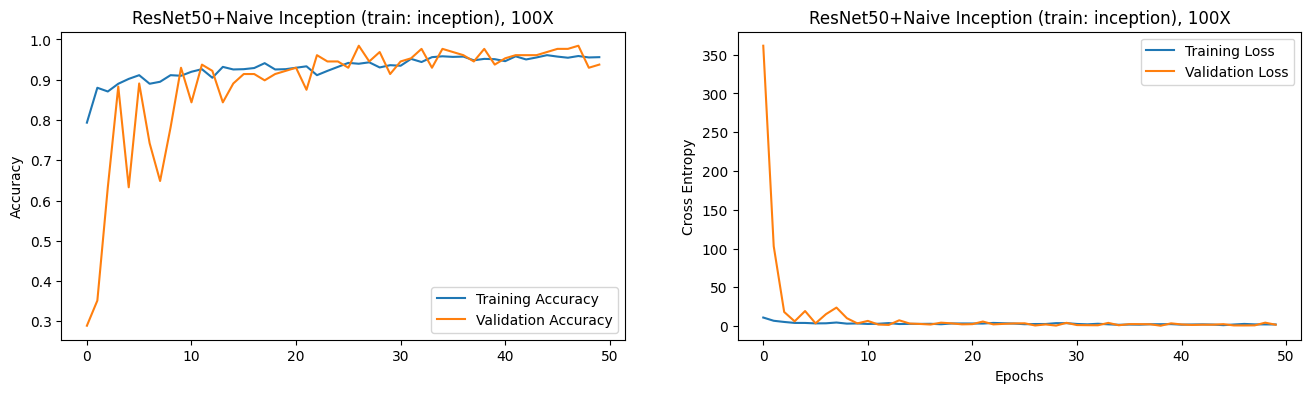

Best model path:  ResNet50_Incept_v01/100X/model-weights.27-0.984375.hdf5
2/2 [==============================] - 1s 55ms/step
Accuracy:  0.9376146788990826
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       161
           1       0.99      0.92      0.95       384

    accuracy                           0.94       545
   macro avg       0.91      0.95      0.93       545
weighted avg       0.94      0.94      0.94       545

input_11 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv

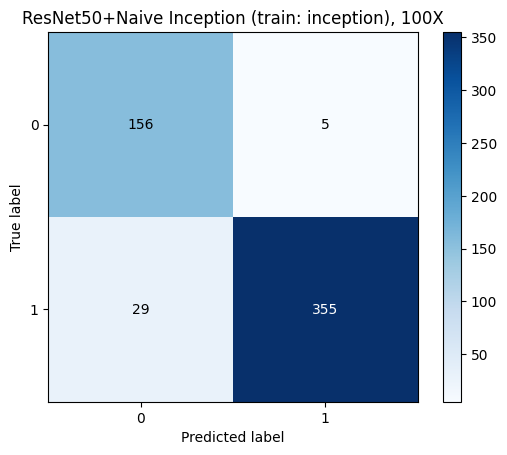

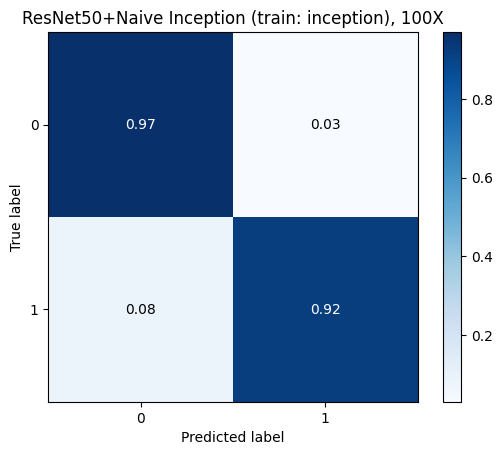

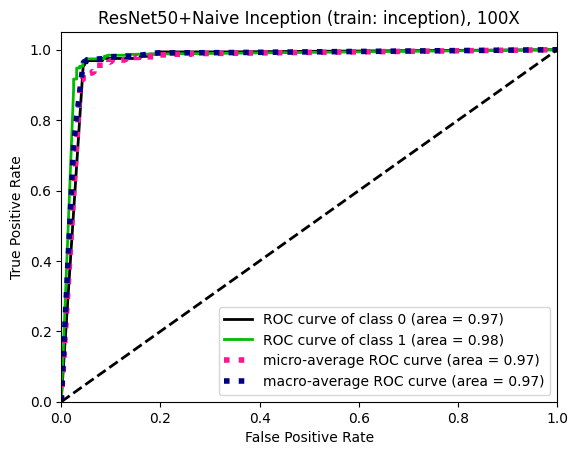

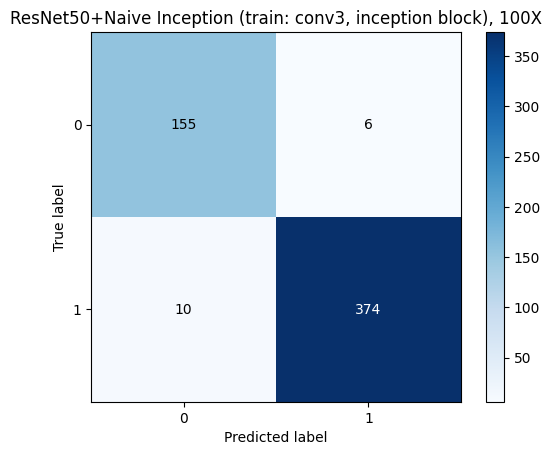

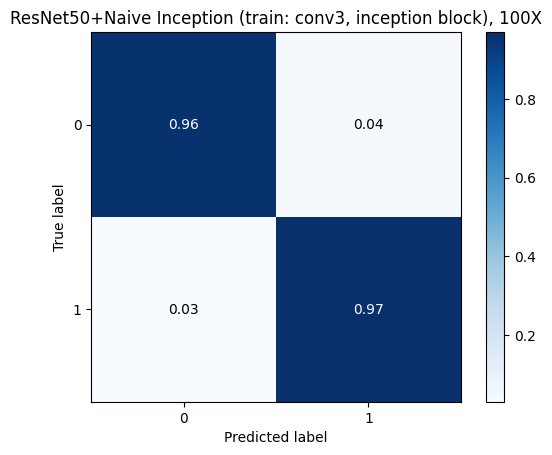

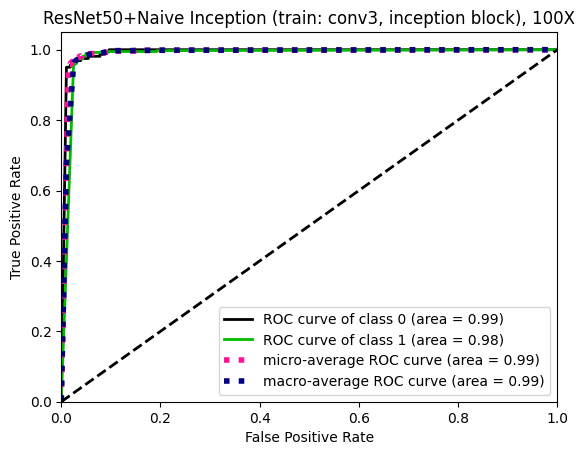

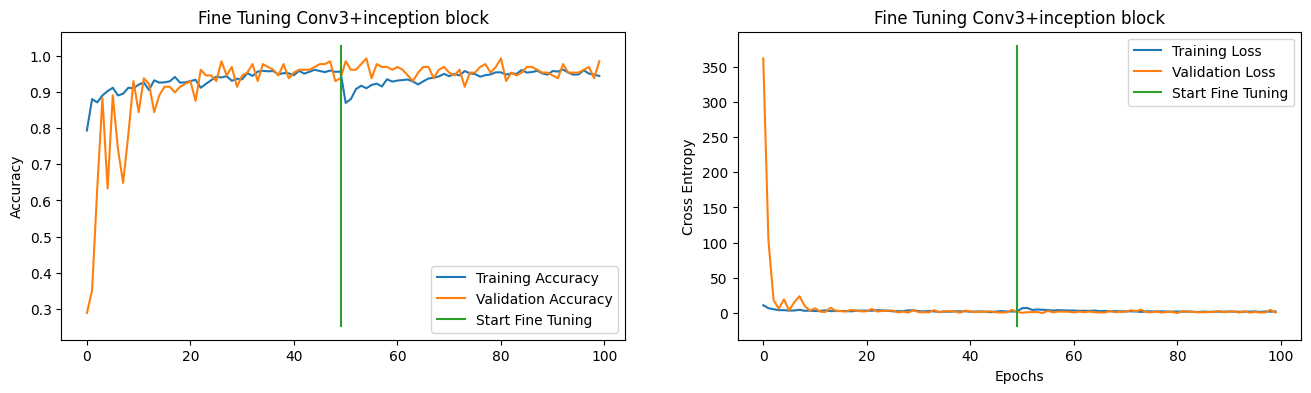

input_11 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv True
conv2_block1_1_bn True
conv2_block1_1_relu True
conv2_block1_2_conv True
conv2_block1_2_bn True
conv2_block1_2_relu True
conv2_block1_0_conv True
conv2_block1_3_conv True
conv2_block1_0_bn True
conv2_block1_3_bn True
conv2_block1_add True
conv2_block1_out True
conv2_block2_1_conv True
conv2_block2_1_bn True
conv2_block2_1_relu True
conv2_block2_2_conv True
conv2_block2_2_bn True
conv2_block2_2_relu True
conv2_block2_3_conv True
conv2_block2_3_bn True
conv2_block2_add True
conv2_block2_out True
conv2_block3_1_conv True
conv2_block3_1_bn True
conv2_block3_1_relu True
conv2_block3_2_conv True
conv2_block3_2_bn True
conv2_block3_2_relu True
conv2_block3_3_conv True
conv2_block3_3_bn True
conv2_block3_add True
conv2_block3_out True
conv3_block1_1_conv True
conv3_block1_1_bn True
conv3_block1_1_relu True
conv3_block1_2_conv True
conv3_block1_2_bn True
conv

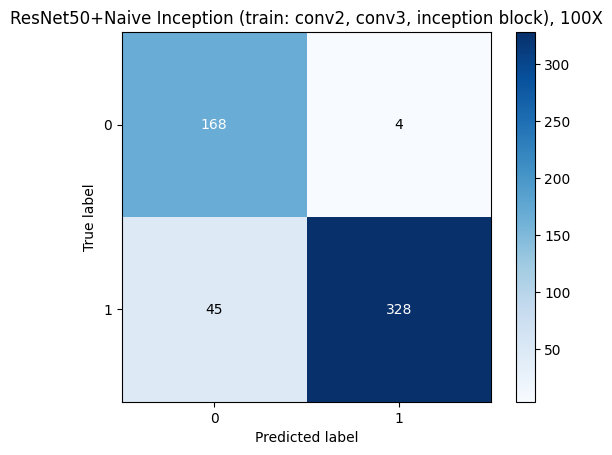

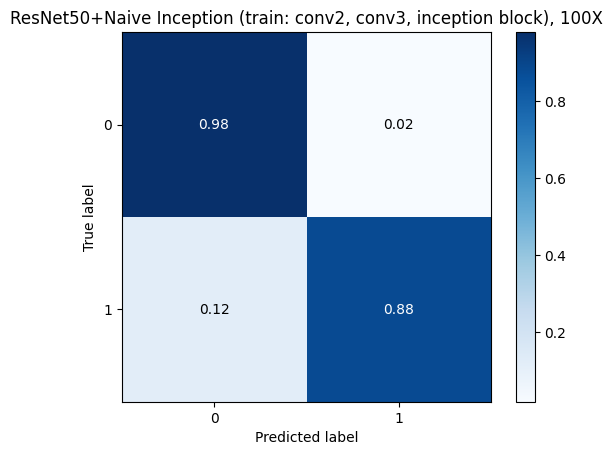

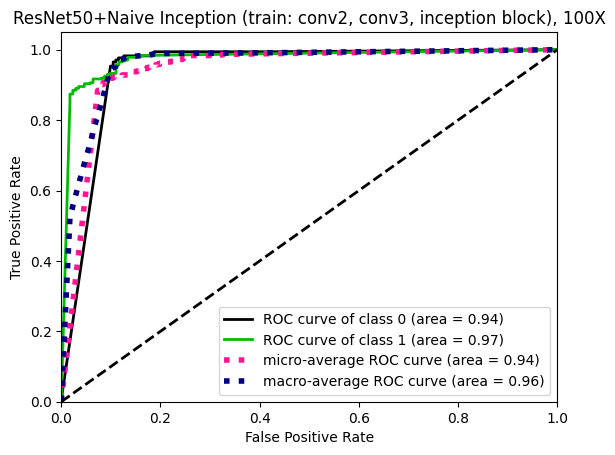

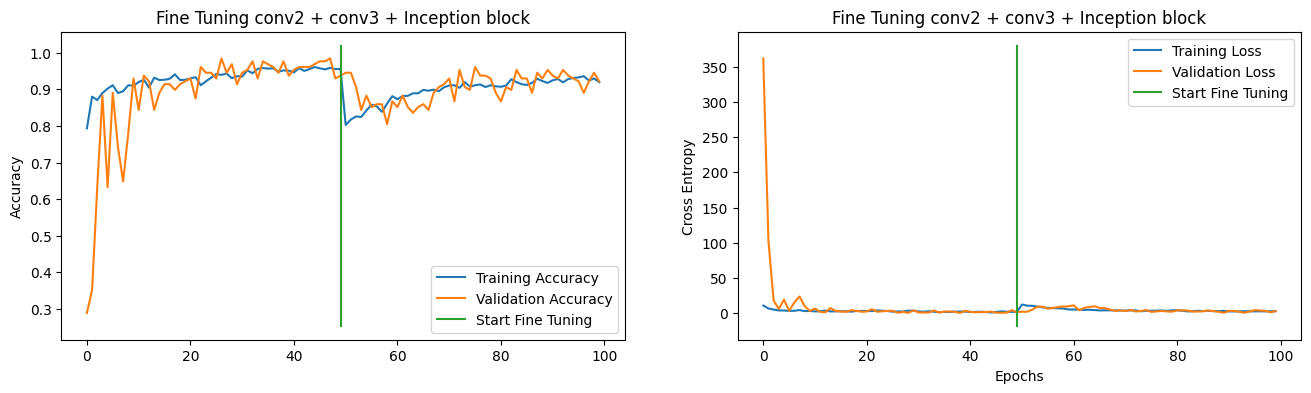

input_11 False
conv1_pad True
conv1_conv True
conv1_bn True
conv1_relu True
pool1_pad False
pool1_pool False
conv2_block1_1_conv True
conv2_block1_1_bn True
conv2_block1_1_relu True
conv2_block1_2_conv True
conv2_block1_2_bn True
conv2_block1_2_relu True
conv2_block1_0_conv True
conv2_block1_3_conv True
conv2_block1_0_bn True
conv2_block1_3_bn True
conv2_block1_add True
conv2_block1_out True
conv2_block2_1_conv True
conv2_block2_1_bn True
conv2_block2_1_relu True
conv2_block2_2_conv True
conv2_block2_2_bn True
conv2_block2_2_relu True
conv2_block2_3_conv True
conv2_block2_3_bn True
conv2_block2_add True
conv2_block2_out True
conv2_block3_1_conv True
conv2_block3_1_bn True
conv2_block3_1_relu True
conv2_block3_2_conv True
conv2_block3_2_bn True
conv2_block3_2_relu True
conv2_block3_3_conv True
conv2_block3_3_bn True
conv2_block3_add True
conv2_block3_out True
conv3_block1_1_conv True
conv3_block1_1_bn True
conv3_block1_1_relu True
conv3_block1_2_conv True
conv3_block1_2_bn True
conv3_bl

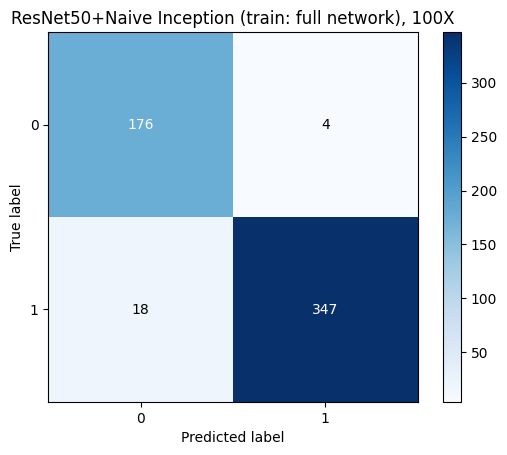

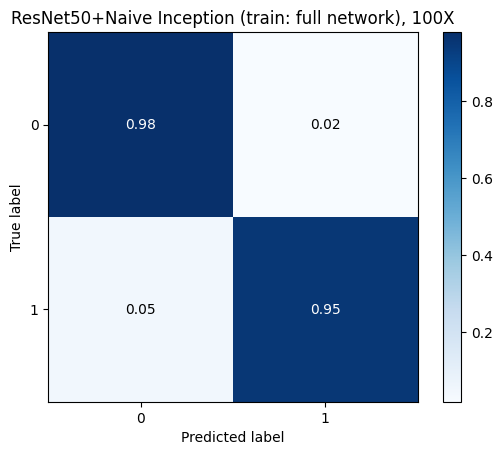

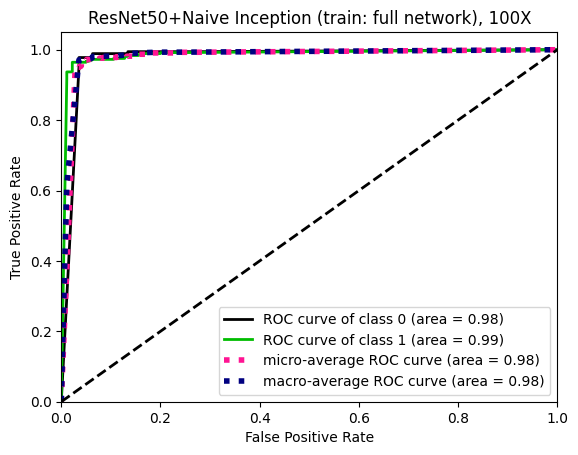

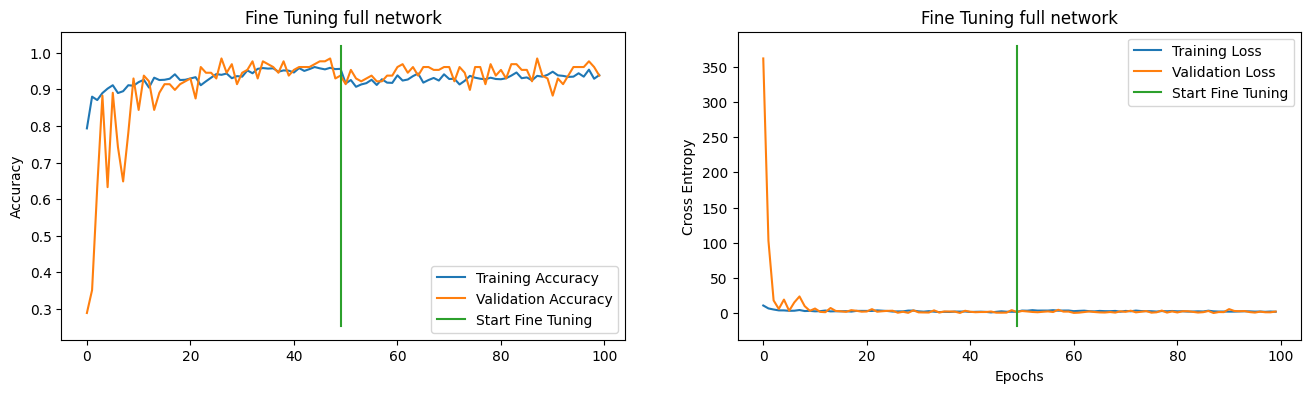

In [ ]:
# Create dataset train, val, test 
train_100x, val_100x, test_100x = dataset('100/') 
iters = 50

folder_proposed_1_100x = "ResNet50_Incept_v01/100X/"
model = resnetinnet_builder() 
model.summary() 
history_100x, model_100x = model_dataset_epoch(model, train_100x, val_100x, test_100x, epoch=iters, folder_path=folder_proposed_1_100x,
                    strategy="train", plot_title="ResNet50+Naive Inception (train: inception), 100X") 


# Fine tuning of Conv3 + Inception block
folder_proposed_2_100x = "ResNet50_Incept_v02/100X/"
model = resnetinnet_builder(finetune=True, model=model_100x, trainable_blocks=['conv3'], print_trainable=True) 
model.summary() 
history_100x_v1, model_100x_v1 = model_dataset_epoch(model, train_100x, val_100x, test_100x, epoch=iters, folder_path=folder_proposed_2_100x,
                    strategy="finetune", plot_title="ResNet50+Naive Inception (train: conv3, inception block), 100X") 
plot_train_history(history_100x, history_100x_v1, title="Fine Tuning Conv3+inception block")  


# Fine tuning of conv2 + conv3 + Inception block
folder_proposed_3_100x = "ResNet50_Incept_v03/100X/"
model = resnetinnet_builder(finetune=True, model=model_100x, trainable_blocks=['conv2', 'conv3'], print_trainable=True) 
model.summary() 
history_100x_v2, model_100x_v2 = model_dataset_epoch(model, train_100x, val_100x, test_100x, epoch=iters, folder_path=folder_proposed_3_100x, 
                    strategy="finetune", plot_title="ResNet50+Naive Inception (train: conv2, conv3, inception block), 100X") 
plot_train_history(history_100x, history_100x_v2, title="Fine Tuning conv2 + conv3 + Inception block")  


# Fine tuning of conv1 + conv2 + conv3 + Inception block
folder_proposed_4_100x = "ResNet50_Incept_v04/100X/"
model = resnetinnet_builder(finetune=True, model=model_100x, trainable_blocks=['conv1','conv2', 'conv3'], print_trainable=True) 
model.summary() 
history_100x_v3, model_100x_v3 = model_dataset_epoch(model, train_100x, val_100x, test_100x, epoch=iters, folder_path=folder_proposed_4_100x,
                    strategy="finetune", plot_title="ResNet50+Naive Inception (train: full network), 100X") 
plot_train_history(history_100x, history_100x_v3, title="Fine Tuning full network")  



### **200X**

Found 2013 files belonging to 2 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50_Preprocess (Lambda)   (None, 224, 224, 3)  0           ['Image_Input[0][0]']            
                                                                                                  
 resnet50_shallow (Functional)  (None, 28, 28, 5

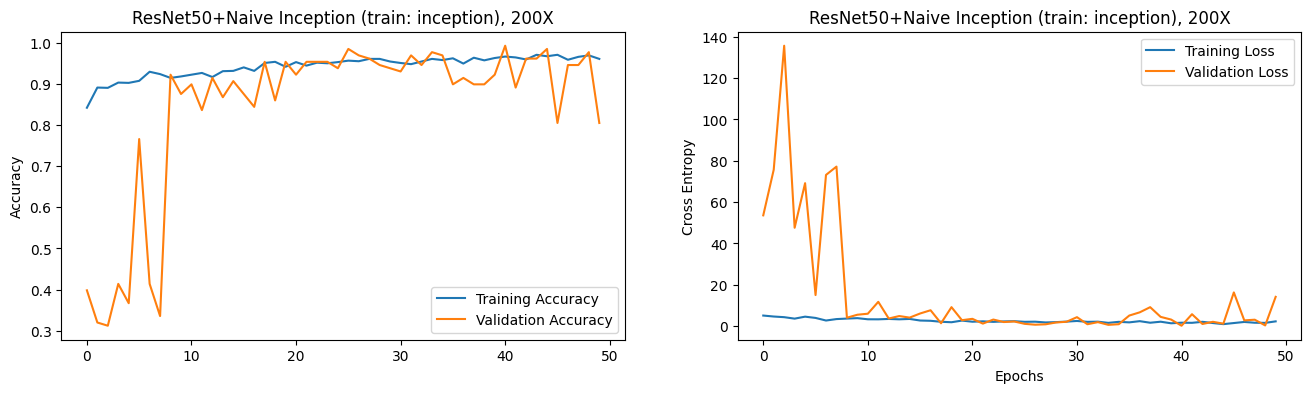

Best model path:  ResNet50_Incept_v01/200X/model-weights.41-0.992188.hdf5
3/3 [==============================] - 1s 166ms/step
Accuracy:  0.9832285115303984
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       144
           1       0.98      0.99      0.99       333

    accuracy                           0.98       477
   macro avg       0.98      0.98      0.98       477
weighted avg       0.98      0.98      0.98       477

input_2 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv

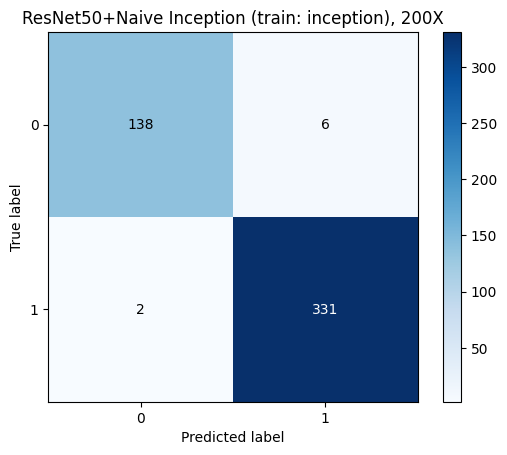

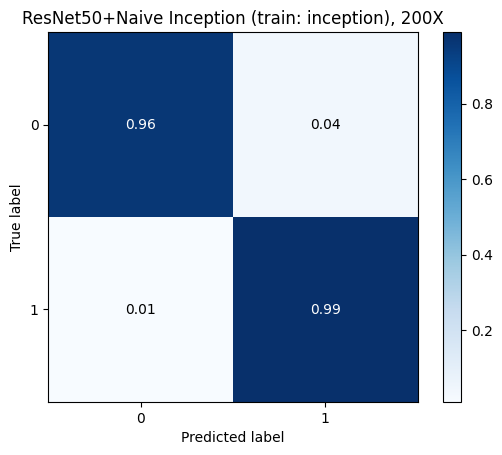

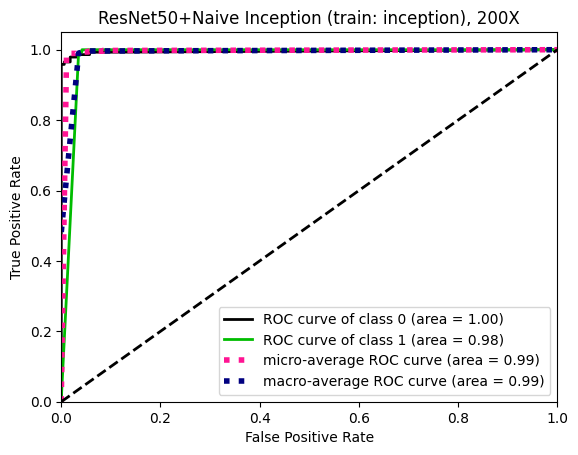

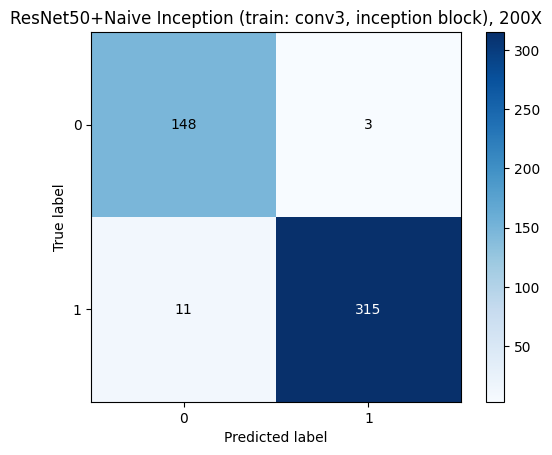

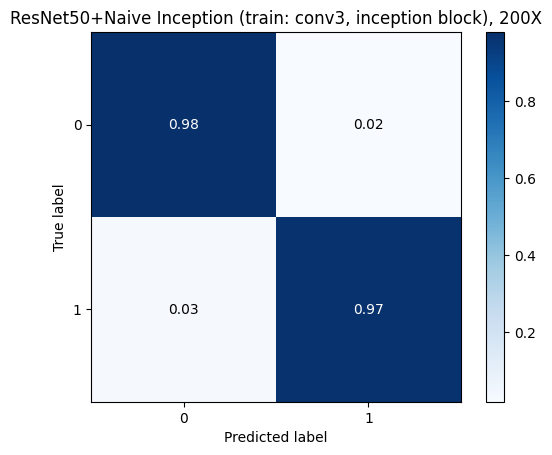

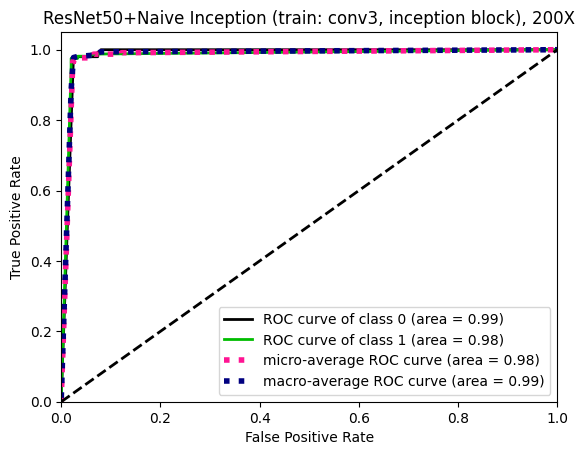

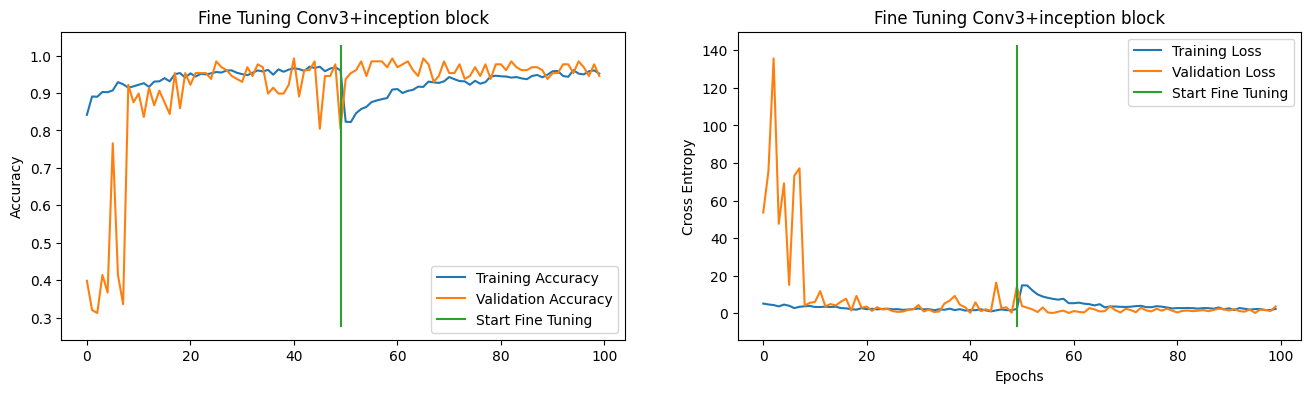

input_2 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv True
conv2_block1_1_bn True
conv2_block1_1_relu True
conv2_block1_2_conv True
conv2_block1_2_bn True
conv2_block1_2_relu True
conv2_block1_0_conv True
conv2_block1_3_conv True
conv2_block1_0_bn True
conv2_block1_3_bn True
conv2_block1_add True
conv2_block1_out True
conv2_block2_1_conv True
conv2_block2_1_bn True
conv2_block2_1_relu True
conv2_block2_2_conv True
conv2_block2_2_bn True
conv2_block2_2_relu True
conv2_block2_3_conv True
conv2_block2_3_bn True
conv2_block2_add True
conv2_block2_out True
conv2_block3_1_conv True
conv2_block3_1_bn True
conv2_block3_1_relu True
conv2_block3_2_conv True
conv2_block3_2_bn True
conv2_block3_2_relu True
conv2_block3_3_conv True
conv2_block3_3_bn True
conv2_block3_add True
conv2_block3_out True
conv3_block1_1_conv True
conv3_block1_1_bn True
conv3_block1_1_relu True
conv3_block1_2_conv True
conv3_block1_2_bn True
conv3

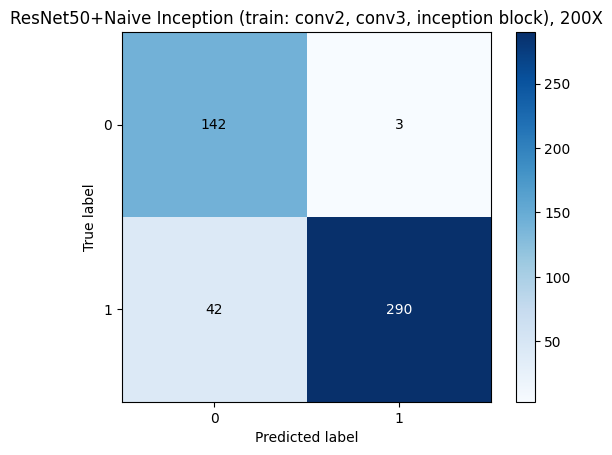

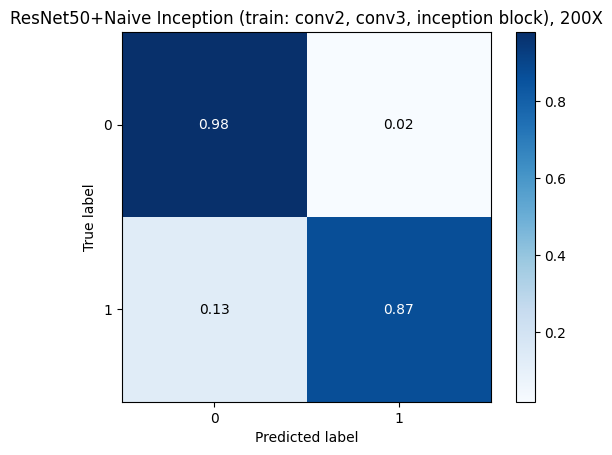

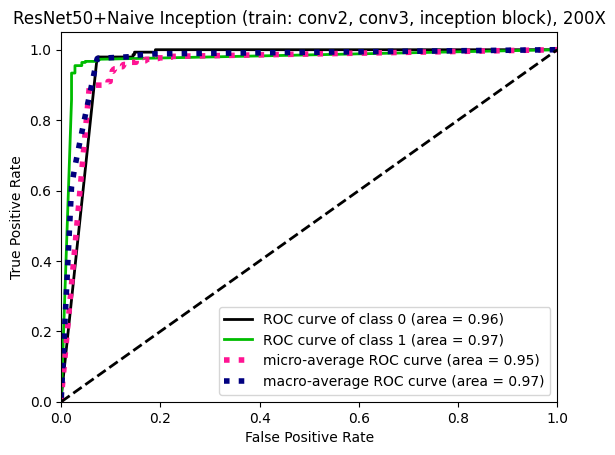

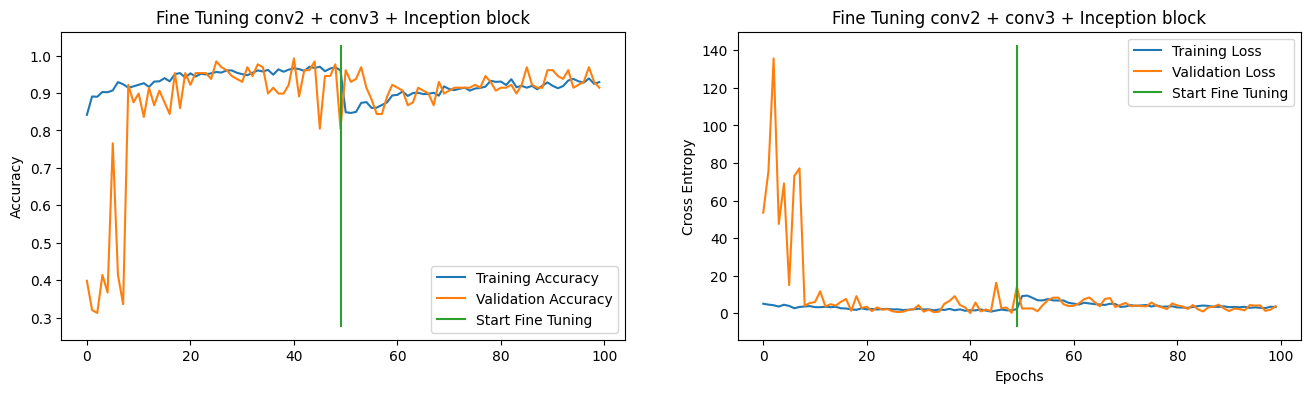

input_2 False
conv1_pad True
conv1_conv True
conv1_bn True
conv1_relu True
pool1_pad False
pool1_pool False
conv2_block1_1_conv True
conv2_block1_1_bn True
conv2_block1_1_relu True
conv2_block1_2_conv True
conv2_block1_2_bn True
conv2_block1_2_relu True
conv2_block1_0_conv True
conv2_block1_3_conv True
conv2_block1_0_bn True
conv2_block1_3_bn True
conv2_block1_add True
conv2_block1_out True
conv2_block2_1_conv True
conv2_block2_1_bn True
conv2_block2_1_relu True
conv2_block2_2_conv True
conv2_block2_2_bn True
conv2_block2_2_relu True
conv2_block2_3_conv True
conv2_block2_3_bn True
conv2_block2_add True
conv2_block2_out True
conv2_block3_1_conv True
conv2_block3_1_bn True
conv2_block3_1_relu True
conv2_block3_2_conv True
conv2_block3_2_bn True
conv2_block3_2_relu True
conv2_block3_3_conv True
conv2_block3_3_bn True
conv2_block3_add True
conv2_block3_out True
conv3_block1_1_conv True
conv3_block1_1_bn True
conv3_block1_1_relu True
conv3_block1_2_conv True
conv3_block1_2_bn True
conv3_blo

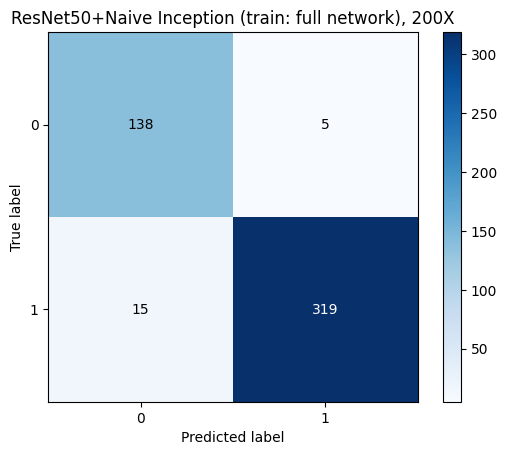

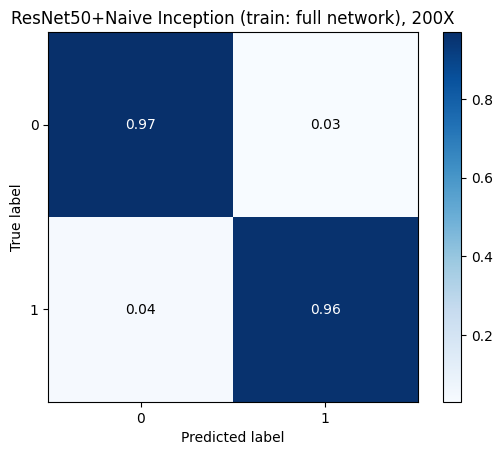

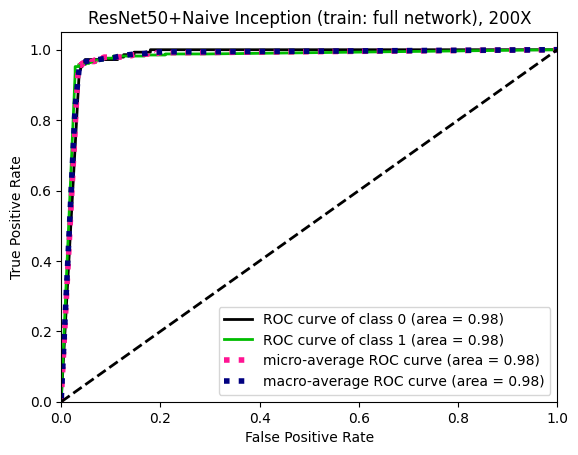

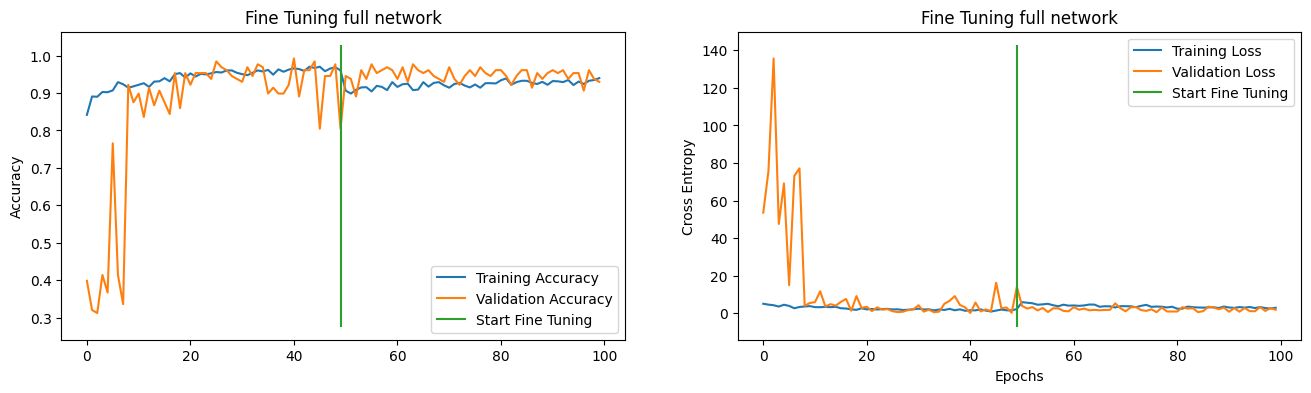

In [ ]:
# Create dataset train, val, test 
train_200x, val_200x, test_200x = dataset('200/') 
iters = 50

folder_proposed_1_200x = "ResNet50_Incept_v01/200X/"
model = resnetinnet_builder() 
model.summary() 
history_200x, model_200x = model_dataset_epoch(model, train_200x, val_200x, test_200x, epoch=iters, folder_path=folder_proposed_1_200x,
                    strategy="train", plot_title="ResNet50+Naive Inception (train: inception), 200X") 


# Fine tuning of Conv3 + Inception block
folder_proposed_2_200x = "ResNet50_Incept_v02/200X/"
model = resnetinnet_builder(finetune=True, model=model_200x, trainable_blocks=['conv3'], print_trainable=True) 
model.summary() 
history_200x_v1, model_200x_v1 = model_dataset_epoch(model, train_200x, val_200x, test_200x, epoch=iters, folder_path=folder_proposed_2_200x,
                    strategy="finetune", plot_title="ResNet50+Naive Inception (train: conv3, inception block), 200X") 
plot_train_history(history_200x, history_200x_v1, title="Fine Tuning Conv3+inception block")  


# Fine tuning of conv2 + conv3 + Inception block
folder_proposed_3_200x = "ResNet50_Incept_v03/200X/"
model = resnetinnet_builder(finetune=True, model=model_200x, trainable_blocks=['conv2', 'conv3'], print_trainable=True) 
model.summary() 
history_200x_v2, model_200x_v2 = model_dataset_epoch(model, train_200x, val_200x, test_200x, epoch=iters, folder_path=folder_proposed_3_200x, 
                    strategy="finetune", plot_title="ResNet50+Naive Inception (train: conv2, conv3, inception block), 200X") 
plot_train_history(history_200x, history_200x_v2, title="Fine Tuning conv2 + conv3 + Inception block")  


# Fine tuning of conv1 + conv2 + conv3 + Inception block
folder_proposed_4_200x = "ResNet50_Incept_v04/200X/"
model = resnetinnet_builder(finetune=True, model=model_200x, trainable_blocks=['conv1','conv2', 'conv3'], print_trainable=True) 
model.summary() 
history_200x_v3, model_200x_v3 = model_dataset_epoch(model, train_200x, val_200x, test_200x, epoch=iters, folder_path=folder_proposed_4_200x,
                    strategy="finetune", plot_title="ResNet50+Naive Inception (train: full network), 200X") 
plot_train_history(history_200x, history_200x_v3, title="Fine Tuning full network")  
